# Dimensionality reduction for image classification

#### Goal

In some of the previous notebooks, we showed how dimensionality reduction allows us to visualize our data. Principal Components Analysis, or PCA, gives us a way to rotate the axes and write our data using much fewer dimensions. 

In our last notebook on PCA, we tried to apply PCA in a naive way to the MNIST dataset, but in this notebook we'll do something more clever!

We will investigate in this notebook how PCA can be used for image classification.

#### Strategy

Recall that the basic idea of PCA was to find the axis rotations that goes through our data, as demonstrated by this figure:

![PCA](https://newonlinecourses.science.psu.edu/stat857/sites/onlinecourses.science.psu.edu.stat857/files/lesson05/PCA_plot/index.gif)

Now let's take that one step further. If we perform a PCA on the subset of the data that corresponds to images of the digit `1`, then the axis that is found will do well at reproducing data from pictures of 1's, but not other digits. 

Therefore, we should be able to do the following:

* perform PCA/find the principal components for the subset of the data pertaining to each image class (the subset of data associated with each unique label)
* transform and reconstruct new, unlabeled images, with each of the sets of principal components/each of the PCA output models trained on each image class
* classify each new image by identifying the PCA model that does the best job of reconstructing the original image from a transformation.

## Data Setup

First let's pull in the MNIST data.

In [2]:
using Flux, Flux.Data.MNIST, Images

imgs = MNIST.images()
labels = MNIST.labels();

INFO: Downloading MNIST dataset
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   469  100   469    0     0   1439      0 --:--:-- --:--:-- --:--:--  1443
100 9680k  100 9680k    0     0  12.3M      0 --:--:-- --:--:-- --:--:-- 12.3M
INFO: Downloading MNIST dataset
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   469  100   469    0     0   2087      0 --:--:-- --:--:-- --:--:--  2093
100 28881  100 28881    0     0  70928      0 --:--:-- --:--:-- --:--:-- 70928
INFO: Downloading MNIST dataset
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   467  100   467    0     0   2129      0 --:--:-- --:--:-- --:--:--  2122
100 1610k  100 1610k    0     0  28

Here's what the first 24 images look like:

,,
,,
,,
,,
,,
,,
,,
,,

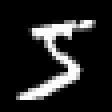
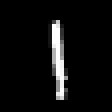
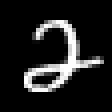
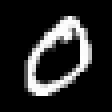
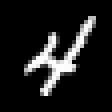
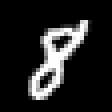
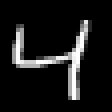
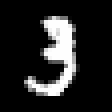
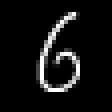
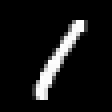
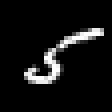
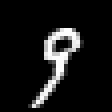
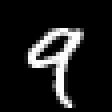
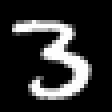
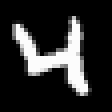
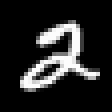
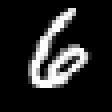
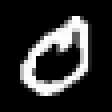
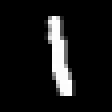
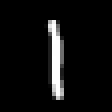
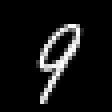
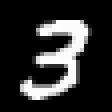
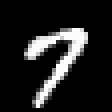
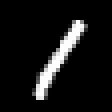

[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1]


In [3]:
display(reshape(imgs[1:24],8,3))
println(labels[1:24]')

There are 60,000 of these images, each with 784 pixels. This means our dataset is of size `784 x 60000`, and our data is 784-dimensional.

In [4]:
matrix =  hcat([vec(Float64.(i)) for i in imgs]...);
size(matrix)

(784, 60000)

## Dimensionality reduction classification

First let's generate training data. The command we use is as follows:

In [54]:
training_size  = 500
singular_vec_size = 25
training_data = [ matrix[:,find(labels.== (i%10))[1:training_size]] for i=0:9];

This makes `training_data[i]` an array of 500 samples for the `i`th digit, i.e. `training_data[5]` is 500 images of the digit `5`. 

Train one PCA model on each of these data subsets (on each of the arrays contained in `training_data`). Store the models in an output called `Ms`.

Note: for simplicity, set a maximum output dimension as 25 when you fit PCA.

#### Solution

In [55]:
using MultivariateStats
Ms = [fit(PCA, training_data[i], maxoutdim = 25) for i=1:10]

10-element Array{MultivariateStats.PCA{Float64},1}:
 PCA(indim = 784, outdim = 25, principalratio = 0.81313)
 PCA(indim = 784, outdim = 25, principalratio = 0.87906)
 PCA(indim = 784, outdim = 25, principalratio = 0.73980)
 PCA(indim = 784, outdim = 25, principalratio = 0.74834)
 PCA(indim = 784, outdim = 25, principalratio = 0.76589)
 PCA(indim = 784, outdim = 25, principalratio = 0.76377)
 PCA(indim = 784, outdim = 25, principalratio = 0.79426)
 PCA(indim = 784, outdim = 25, principalratio = 0.79719)
 PCA(indim = 784, outdim = 25, principalratio = 0.72730)
 PCA(indim = 784, outdim = 25, principalratio = 0.79546)

Now we have that `Ms[i]` is the PCA model for the `i`th digit. Now let's calculate how well each PCA does on an image. The way we do this is to take a data point (a column of `matrix`). Then, for each PCA model

1. Transform to the PC axis (dimensionality reduce)
2. Reconstruct the original data point by reversing the dimensionality reduction
3. Calculate the difference between the original data point and the reconstructed data point

At this point, you should be able to classify the image associated with the original data point by identifying the PCA model that does the best at reconstructing it.

Write a function that takes the dataset (`matrix`), chooses a random image from it, and returns both the image's label and its classification. 

#### Solution

In [58]:
function test_classification(data, labels, models)
    # Choose a random data point/image
    i = rand(1:size(data, 2))
    point = data[:, i]
    true_label = labels[i]
    # initialize the reconstruction cost to infinity
    # and the classification to "unlabeled"
    # These will be updated for every model in the input
    # `models` until the best one is found.
    min_reconstruction_cost = Inf
    classification = "unlabeled"
    
    N = length(models)
    for j in 1:N
        # transform and reconstruct the image
        y = transform(Ms[j], point)
        reconstructed = reconstruct(Ms[j], y)
        # calculate a "cost" of reconstructing with this model
        reconstruction_cost = sum(abs2, reconstructed .- point)
        if reconstruction_cost < min_reconstruction_cost
            min_reconstruction_cost = reconstruction_cost
            classification = j - 1 # Digits are 0 to 9, not 1 to 10
        end
    end
   return true_label, classification 
end

test_classification (generic function with 1 method)

In [82]:
for i in 1:20
    println(test_classification(matrix, labels, Ms))
end

(1, 1)
(2, 2)
(5, 5)
(1, 1)
(4, 4)
(2, 2)
(8, 8)
(7, 7)
(6, 6)
(8, 8)
(1, 1)
(1, 1)
(8, 8)
(7, 7)
(4, 4)
(2, 2)
(0, 0)
(1, 1)
(6, 6)
(9, 9)


In [83]:
# Alternatively

function test_classification2(data, labels, models)
    # Choose a random data point/image
    i = rand(1:size(data, 2))
    point = data[:, i]
    true_label = labels[i]

    # store costs
    costs = rand(10)
    N = length(models)
    for j in 1:N
        # transform and reconstruct the image
        y = transform(Ms[j], point)
        reconstructed = reconstruct(Ms[j], y)
        # calculate a "cost" of reconstructing with this model
        costs[j] = sum(abs2, reconstructed .- point)
    end
    classification = findmin(costs)[2] - 1
    return true_label, classification 
end

test_classification2 (generic function with 1 method)

In [84]:
for i in 1:20
    println(test_classification2(matrix, labels, Ms))
end

(7, 7)
(8, 8)
(2, 2)
(8, 8)
(7, 7)
(9, 9)
(4, 4)
(9, 9)
(9, 9)
(0, 0)
(9, 9)
(8, 8)
(7, 7)
(3, 3)
(8, 8)
(3, 3)
(8, 8)
(3, 3)
(7, 7)
(2, 2)


The above is the solution to what was asked for, but here's some more code that may help you see what's going on:

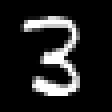

In [86]:
# Select a random image
rand_img_idx = rand(1:length(imgs))
rand_img = imgs[rand_img_idx]
display(rand_img)

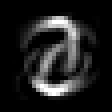

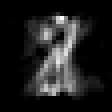

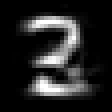

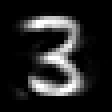

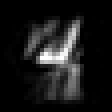

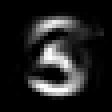

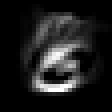

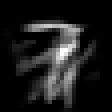

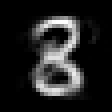

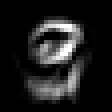

In [87]:
# Examine each possible model-- show a reconstructed image
costs = []
for midx in 1:10
    model = Ms[midx]
    reduced_img = transform(model, matrix[:, rand_img_idx])
    reconstructed_img = reconstruct(model, reduced_img)
    display(Gray.(reshape(reconstructed_img, (28, 28))))
    reconstruction_cost = sum(abs2, matrix[:, rand_img_idx] .- reconstructed_img)
    push!(costs, reconstruction_cost)
end

In [88]:
findmin(costs)

(10.375548559625937, 4)

In [90]:
model_number = findmin(costs)[2]

4

In [91]:
classification = model_number - 1

3

In [92]:
true_label = labels[rand_img_idx]

3

## Conclusion

One way to think about dimensionality reduction is as information retention. Dimensionality reduction models try to retain as much information as possible with as few numbers as possible. Different pieces of the dataset utilize different numbers, and thus the way you would want to dimensionally reduce is dependent on what you want to store. For the pictures of apples, the mean of the red pixels and the height of the apple might be most of the information, while for a banana the height may not be a differentiating factor. Thus by seeing how the dimensionality reduction is able to reproduce the image, we are able to back out what image we are looking at!

## Mathematical bonus (Optional, for the mathematically-inclined!)

Above we used statistics packages for dimensionality reduction, but we could do this directly by using the 
**singular value decomposition** (SVD). This is the mathematical operation of finding a matrix factorization `A = U S V'`, where `U`'s leading columns are a low rank approximation to `A`. Thus we can generate projection matrices using this matrix from the factorization:

In [ ]:
u = [svdfact(training_data[i])[:U][:,1:singular_vec_size] for i=1:10];

And then we can classify based on the reconstruction error using this low-rank approximation

In [ ]:
z = vcat([sum((u[i]'matrix).^2,1) for i=1:10]...)
result = rem.( [ findmax(z[:,i])[2] for i=1:60000] ,10)
mean(result .== labels)

Notice that we get the same result. This shows that, internally, PCA is the dimensionality reduction algorithm which is simply using the low-rank approximation of an SVD factorization!